## Clustering with Logic Tensor Networks

This is a basic example in which we use LTN for unsupervised clustering in a 2d space of real numbers. We define a theory that encodes the following facts
* every point in the sample set should be assigned to a cluster
* clusters should be to be disjoint
* if two points are close, they should belong to the same cluster

We start generating normally distributed samples from $\mathrm{nr\_of\_clusters}$ clusters. We use this to setup the theory and then optimize a loss function defined on the theory.

In [1]:
import logging; logging.basicConfig(level=logging.INFO)
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import logictensornetworks_wrapper as ltnw
ltnw.ltn.set_universal_aggreg("min")
ltnw.ltn.set_existential_aggregator("max")
ltnw.ltn.set_tnorm("prod")
ltnw.ltn.LAYERS = 4

Generate $\mathrm{nr\_of\_points\_x\_cluster}$ samples for $\mathrm{nr\_of\_clusters}$ clusters. Every sample is drawn from a normal distribution that is the underlying generator for each cluster. Samples from $\mathbb{R}$^2

In [2]:
nr_of_clusters = 4
nr_of_points_x_cluster = 50
cov = np.array([[.01,0],[0,.01]])

clusters=[]
for i in range(nr_of_clusters):
    mean = np.random.uniform([-1,-1],[1,1],2).astype(np.float32)    
    clusters.append(np.random.multivariate_normal(mean=mean,cov=cov,size=nr_of_points_x_cluster).astype(np.float32) )

Every cluster is represented by a unary predicate $C_0,..C_{\mathrm{nr\_of\_clusters}-1}$

In [3]:
[ltnw.predicate("C_"+str(i),2) for i in range(nr_of_clusters)]
print("\n".join(ltnw.PREDICATES.keys()))

C_0
C_1
C_2
C_3


We define the theory using a number of variables. First, we define two variables $x,y$ that encompass the complete sample set.

In [4]:
data  = np.concatenate(clusters)
ltnw.variable("?x",data);
ltnw.variable("?y",data);

Furthermore, we define two variables that encode distance relations. The variable $\mathrm{?close\_x\_y}$ encodes points that are close. The variable $\mathrm{?distant\_x\_y}$ encodes points that are distant. The data for these variables encodes relations. Each row is a vector with 4 dimensions. 2 dimensions are for the first sample, 2 dimensions for the second.

In [5]:
close_data = np.array([np.concatenate([data[i],data[j]])
                             for i in range(len(data))
                             for j in range(i,len(data))
                             if np.sum(np.square(data[i]-data[j])) < np.square(.5)])

close_data = close_data[np.random.randint(0,len(data),1000)]
distant_data = np.array([np.concatenate([data[i],data[j]])
                             for i in range(len(data))
                             for j in range(len(data))
                             if np.sum(np.square(data[i]-data[j])) > np.square(1.)])

ltnw.variable("?close_x_y",close_data);
ltnw.variable("?distant_x_y",distant_data);

Because $\mathrm{?close\_x\_y}$ and $\mathrm{?distant\_x\_y}$ are 4 dimensionals we need a way to retrieve the samples of each row. For this, we define two functions for retrieving the first part and the second part of the relation.

In [6]:
ltnw.function("first",2,fun_definition=lambda d:d[:,:2]);
ltnw.function("second",2,fun_definition=lambda d:d[:,2:]);

Next we can define the theory.

In [7]:
ltnw.formula("forall ?x: %s" % "|".join(["C_%s(?x)" % i for i in range(nr_of_clusters)]))
for i in range(nr_of_clusters):
    ltnw.formula("exists ?x: C_%s(?x)" % i)
    ltnw.formula("forall ?close_x_y: C_%s(first(?close_x_y)) %% C_%s(second(?close_x_y))" % (i,i))
    ltnw.formula("forall ?distant_x_y: C_%s(first(?distant_x_y)) %% C_%s(second(?distant_x_y))" % (i,i))
    for j in range(i+1,nr_of_clusters):
        ltnw.formula("forall ?x: ~(C_%s(?x) & C_%s(?x))" % (i,j))
print("%s" % "\n".join(sorted(ltnw.FORMULAS.keys())))


exists ?x: C_0(?x)
exists ?x: C_1(?x)
exists ?x: C_2(?x)
exists ?x: C_3(?x)
forall ?close_x_y: C_0(first(?close_x_y)) % C_0(second(?close_x_y))
forall ?close_x_y: C_1(first(?close_x_y)) % C_1(second(?close_x_y))
forall ?close_x_y: C_2(first(?close_x_y)) % C_2(second(?close_x_y))
forall ?close_x_y: C_3(first(?close_x_y)) % C_3(second(?close_x_y))
forall ?distant_x_y: C_0(first(?distant_x_y)) % C_0(second(?distant_x_y))
forall ?distant_x_y: C_1(first(?distant_x_y)) % C_1(second(?distant_x_y))
forall ?distant_x_y: C_2(first(?distant_x_y)) % C_2(second(?distant_x_y))
forall ?distant_x_y: C_3(first(?distant_x_y)) % C_3(second(?distant_x_y))
forall ?x: C_0(?x)|C_1(?x)|C_2(?x)|C_3(?x)
forall ?x: ~(C_0(?x) & C_1(?x))
forall ?x: ~(C_0(?x) & C_2(?x))
forall ?x: ~(C_0(?x) & C_3(?x))
forall ?x: ~(C_1(?x) & C_2(?x))
forall ?x: ~(C_1(?x) & C_3(?x))
forall ?x: ~(C_2(?x) & C_3(?x))


Initialize the knowledgebase and optimize

In [8]:
ltnw.initialize_knowledgebase(optimizer=tf.train.RMSPropOptimizer(learning_rate=0.01,decay=.9),
                              initial_sat_level_threshold=.5)

ltnw.train(max_epochs=100)

INFO:logictensornetworks_wrapper:Initializing knowledgebase
INFO:logictensornetworks_wrapper:Initializing optimizer
INFO:logictensornetworks_wrapper:Assembling feed dict
INFO:logictensornetworks_wrapper:Initializing Tensorflow session
INFO:logictensornetworks_wrapper:INITIALIZED with sat level = 0.75504947
INFO:logictensornetworks_wrapper:TRAINING 0 sat level -----> 0.75504947


0.81594604

Visualize results

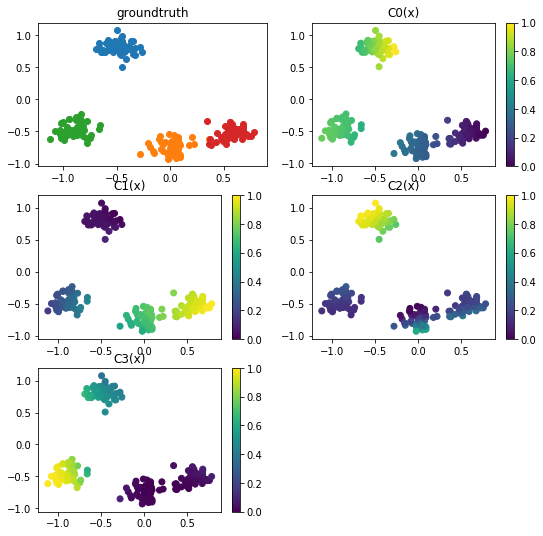

In [9]:
prC = [ltnw.ask("C_%s(?x)" % i) for i in range(nr_of_clusters)]
n = 2
m = (nr_of_clusters + 1) // n + 1

fig = plt.figure(figsize=(3 * 3, m * 3))

fig.add_subplot(m, n, 1)
plt.title("groundtruth")
for c in clusters:
    plt.scatter(c[:, 0], c[:, 1])
data=np.concatenate(clusters)
x0 = data[:, 0]
x1 = data[:, 1]
for i in range(nr_of_clusters):
    fig.add_subplot(m, n, i + 2)
    plt.title("C" + str(i) + "(x)")
    plt.scatter(x0, x1, c=prC[i].T[0])
    plt.scatter(x0[:2], x1[:2], s=0, c=[0, 1])
    plt.colorbar()
plt.show()